一方面，训练复杂的深度学习模型可能需要数小时、几天甚至数周。优化算法的性能直接影响模型的训练效率。另一方面，了解不同优化算法的原则及其超参数的作用将使我们能够以有针对性的方式调整超参数，以提高深度学习模型的性能。

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
import torch
from torch import nn
from d2l import torch as d2l

!pip uninstall matplotlib -y
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-6jz5wsvm
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-6jz5wsvm
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 15.0 MB/s 
     |████████████████████████████████| 11.2 MB 52.8 MB/s 
     |████████████████████████████████| 61 kB 8.8 MB/s 
     |████████████████████████████████| 9.9 MB 45.1 MB/s 
     |████████████████████████████████| 930 kB 47.3 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=53dc138c07b45512ca53af2d4ea04298eefb1e114406e181f33ed5d4cbd39bed
  Stored in directory: /tmp/pip-ephem-wh

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 2.0.0b0 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2

# 11.1. 优化和深度学习

对于深度学习问题，我们通常会先定义损失函数。一旦我们有了损失函数，我们就可以使用优化算法来尝试最小化损失。在优化中，损失函数通常被称为优化问题的目标函数。按照传统和惯则，大多数优化算法都关注的是最小化。如果我们需要最大化目标，那么有一个简单的解决方案：在目标函数前加负号即可。

## 11.1.1. 优化的目标

In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

为了说明上述不同的目标，让我们考虑经验风险和风险。经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失。下面我们定义了两个函数：风险函数f和经验风险函数g。假设我们只有有限量的训练数据。因此，这里的g不如f平滑。

In [ ]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

下图说明，训练数据集的最低经验风险可能与最低风险（泛化误差）不同。

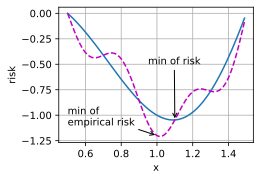

In [ ]:
def annotate(text, xy, xytext): 
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

## 11.1.2. 深度学习中的优化挑战

在本章中，我们将特别关注优化算法在最小化目标函数方面的性能，而不是模型的泛化误差。在深度学习中，大多数目标函数都很复杂，没有解析解。相反，我们必须使用数值优化算法。本章中的优化算法都属于此类别。

深度学习优化存在许多挑战。其中一些最令人烦恼的是局部最小值、鞍点和梯度消失。让我们来看看它们。

### 11.1.2.1. 局部最小值

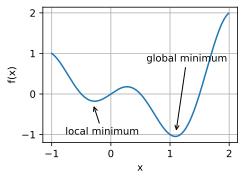

In [ ]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数通常有许多局部最优解。当优化问题的数值解接近局部最优值时，随着目标函数解的梯度接近或变为零，通过最终迭代获得的数值解可能仅使目标函数局部最优，而不是全局最优。只有一定程度的噪声可能会使参数超出局部最小值。事实上，这是小批量随机梯度下降的有利特性之一，在这种情况下，小批量上梯度的自然变化能够将参数从局部极小值中移出。

### 11.1.2.2. 鞍点

除了局部最小值之外，鞍点也是梯度消失的另一个原因。*鞍点*（saddle point）是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。考虑这个函数$f(x) = x^3$。它的一阶和二阶导数在$x=0$时消失。这时优化可能会停止，尽管它不是最小值。

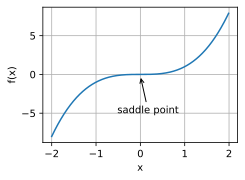

In [ ]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


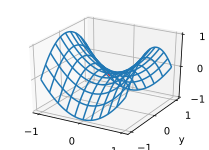

In [ ]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

我们假设函数的输入是$k$维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有$k$特征值。函数的解决方案可以是局部最小值、局部最大值或函数梯度为零的位置处的鞍点：

* 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值。
* 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值。
* 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们对函数有一个鞍点。

对于高维度问题，至少*部分*特征值为负的可能性相当高。这使得鞍点比局部最小值更有可能。我们将在下一节介绍凸性时讨论这种情况的一些例外情况。简而言之，凸函数是Hessian函数的特征值永远不是负值的函数。不幸的是，大多数深度学习问题并不属于这个类别。尽管如此，它还是研究优化算法的一个很好的工具。

### 11.1.2.3. 梯度消失

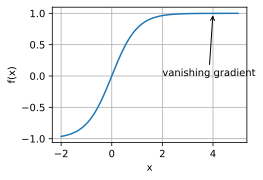

In [ ]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

# 11.2. 凸性

In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## 11.2.1. 定义

在进行凸分析之前，我们需要定义凸集（convex sets）和凸函数（convex functions）。

### 11.2.1.1. 凸集

*凸集*（convex set）是凸性的基础。简单地说，如果对于任何$a，b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是*凸*（convex）的。

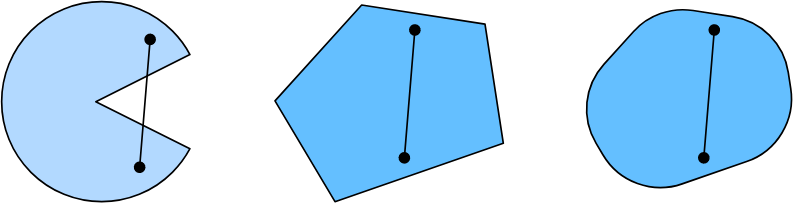

通常，深度学习中的问题是在凸集上定义的。

### 11.2.1.2. 凸函数

现在我们有了凸集，我们可以引入*凸函数*（convex function）$f$。给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，一个函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

为了说明这一点，让我们绘制一些函数并检查哪些函数满足要求。下面我们定义一些函数，包括凸函数和非凸函数。

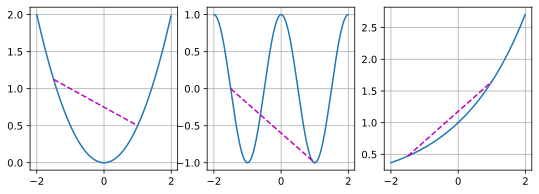

In [ ]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

不出所料，余弦函数为非凸的，而抛物线函数和指数函数为凸的。

### 11.2.1.3. 詹森不等式

## 11.2.2. 性质

### 11.2.2.1. 局部极小值是全局极小值

首先凸函数的局部极小值也是全局极小值。

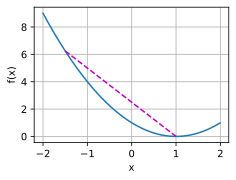

In [ ]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

### 11.2.2.2. 凸函数的下水平集是凸的

### 11.2.2.3. 凸性和二阶导数

## 11.2.3. 约束

凸优化的一个很好的特性是能够让我们有效地处理*约束*（constraints）。即它使我们能够解决以下形式的*约束优化*（constrained optimization）问题：

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

这里$f$是目标函数，$c_i$是约束函数。

### 11.2.3.1. 拉格朗日函数 

### 11.2.3.2. 惩罚

### 11.2.3.3. 投影

# 11.3. 梯度下降

尽管梯度下降（gradient descent）很少直接用于深度学习，但了解它是理解下一节随机梯度下降算法的关键。例如，由于学习率过大，优化问题可能会发散，这种现象早已在梯度下降中出现。同样地，预处理（preconditioning）是梯度下降中的一种常用技术，还被沿用到更高级的算法中。让我们从简单的一维梯度下降开始。

## 11.3.1. 一维梯度下降

In [ ]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

def f(x):  # 目标函数
    return x ** 2

def f_grad(x):  # 目标函数的梯度(导数)
    return 2 * x

接下来，我们使用$x=10$作为初始值，并假设$\eta=0.2$。使用梯度下降法迭代$x$共10次，我们可以看到，$x$的值最终将接近最优解。

In [ ]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进行$x$优化的过程可以绘制如下。

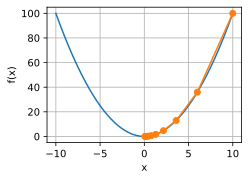

In [ ]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### 11.3.1.1. 学习率

*学习率*（learning rate）决定目标函数能否收敛到局部最小值，以及何时收敛到最小值。学习率$\eta$可由算法设计者设置。请注意，如果我们使用的学习率太小，将导致$x$的更新非常缓慢，需要更多的迭代。例如，考虑同一优化问题中$\eta = 0.05$的进度。如下所示，尽管经过了10个步骤，我们仍然离最优解很远。

epoch 10, x: 3.486784


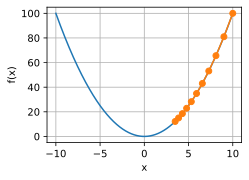

In [ ]:
show_trace(gd(0.05, f_grad), f)

相反，如果我们使用过高的学习率，在这种情况下，$x$的迭代不能保证降低$f(x)$的值。例如，当学习率为$\eta=1.1$时，$x$超出了最优解$x=0$并逐渐发散。

epoch 10, x: 61.917364


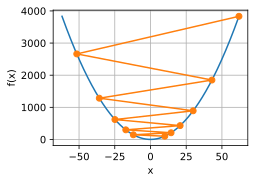

In [ ]:
show_trace(gd(1.1, f_grad), f)

### 11.3.1.2. 局部最小值

epoch 10, x: -1.528166


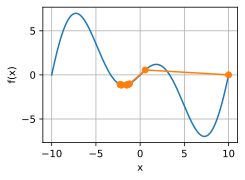

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

## 11.3.2. 多元梯度下降

In [ ]:
def train_2d(trainer, steps=20, f_grad=None): 
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results): 
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


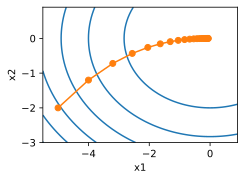

In [ ]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 11.3.3. 自适应方法

选择“恰到好处”的学习率$\eta$是很棘手的。如果我们把它选得太小，就没有什么进展；如果太大，得到的解就会振荡，甚至可能发散。如果我们可以自动确定$\eta$，或者完全不必选择学习率，会怎么样？除了考虑目标函数的值和梯度、还考虑它的曲率的二阶方法可以帮我们解决这个问题。虽然由于计算代价的原因，这些方法不能直接应用于深度学习，但它们为如何设计高级优化算法提供了有用的思维直觉，这些算法可以模拟下面概述的算法的许多理想特性。


### 11.3.3.1. 牛顿法

epoch 10, x: tensor(0.)


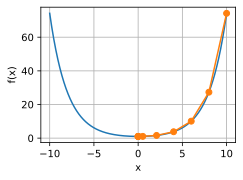

In [ ]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

epoch 10, x: tensor(26.8341)


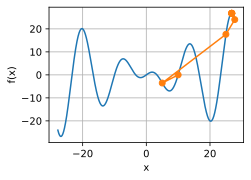

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？一种方法是用取Hessian的绝对值来修正，另一个策略是重新引入学习率。这似乎违背了初衷，但不完全是——拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。

epoch 10, x: tensor(7.2699)


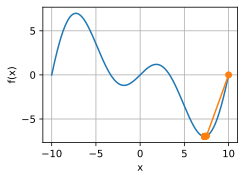

In [ ]:
show_trace(newton(0.5), f)

### 11.3.3.2. 收敛性分析

### 11.3.3.3. 预处理

### 11.3.3.4. 梯度下降和线搜索

# 11.4. 随机梯度下降

In [ ]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## 11.4.1. 随机梯度更新

在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。给定$n$个样本的训练数据集，我们假设$f_i(\mathbf{x})$是关于索引$i$的训练样本的损失函数，其中$\mathbf{x}$是参数向量。然后我们得到目标函数

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

$\mathbf{x}$的目标函数的梯度计算为

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

如果使用梯度下降法，则每个自变量迭代的计算代价为$\mathcal{O}(n)$，它随$n$线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。

随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机均匀采样一个索引$i$，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中$\eta$是学习率。我们可以看到，每次迭代的计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，我们要强调，随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

这意味着，平均而言，随机梯度是对梯度的良好估计。

现在，我们将把它与梯度下降进行比较，方法是向梯度添加均值为0、方差为1的随机噪声，以模拟随机梯度下降。

In [ ]:
def f(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # 目标函数的梯度
    return 2 * x1, 4 * x2

In [ ]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: 0.027433, x2: -0.120681


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


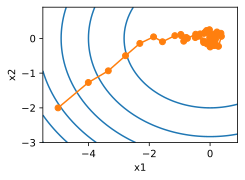

In [ ]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # 常数学习速度
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最小值，我们仍然受到通过$\eta \nabla f_i(\mathbf{x})$的瞬间梯度所注入的不确定性的影响。即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到改善（我们鼓励你尝试更多的步骤来确认这一点）。这给我们留下了唯一的选择：改变学习率$\eta$。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，如上所示。解决这些相互冲突的目标的唯一方法是在优化过程中*动态*降低学习率。

这也是在`sgd`步长函数中添加学习率函数`lr`的原因。在上面的示例中，学习率调度的任何功能都处于休眠状态，因为我们将相关的`lr`函数设置为常量。

## 11.4.2. 动态学习率

用与时间相关的学习率$\eta(t)$取代$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$

在第一个*分段常数*（piecewise constant）场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过*指数衰减*（exponential decay）来更积极地减低它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是$\alpha = 0.5$的*多项式衰减*（polynomial decay）。在凸优化的情况下，有许多证据表明这种速率表现良好。

让我们看看指数衰减在实践中是什么样子。


epoch 1000, x1: -0.778139, x2: 0.000543


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


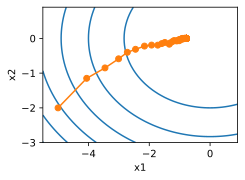

In [ ]:
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的方差大大减少。但是，这是以未能收敛到最优解$\mathbf{x} = (0, 0)$为代价的。即使经过1000个迭代步骤，我们仍然离最优解很远。事实上，该算法根本无法收敛。另一方面，如果我们使用多项式衰减，其中学习率随迭代次数的平方根倒数衰减，那么仅在50次迭代之后，收敛就会更好。


epoch 50, x1: 0.164005, x2: -0.008660


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


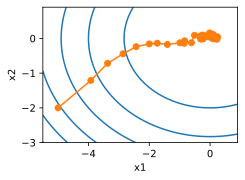

In [ ]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

关于如何设置学习率，还有更多的选择。例如，我们可以从较小的学习率开始，然后使其迅速上涨，再让它降低，尽管这会更慢。我们甚至可以在较小和较大的学习率之间切换。

## 11.4.3. 凸目标的收敛性分析

## 11.4.4. 随机梯度和有限样本

# 11.5. 小批量随机梯度下降

## 11.5.1. 向量化和缓存

使用小批量的决策的核心是计算效率。当考虑与多个GPU和多台服务器并行处理时，这一点最容易被理解。在这种情况下，我们需要向每个GPU发送至少一张图像。有了每台服务器8个GPU和16台服务器，我们就能得到大小为128的小批量。

当涉及到单个GPU甚至CPU时，事情会更微妙一些：这些设备有多种类型的内存、通常情况下多种类型的计算单元以及在它们之间不同的带宽限制。例如，一个CPU有少量寄存器（register），L1和L2缓存，以及L3缓存（在不同的处理器内核之间共享）。随着缓存的大小的增加，它们的延迟也在增加，同时带宽在减少。可以说，处理器能够执行的操作远比主内存接口所能提供的多得多。

In [ ]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [ ]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

2.0383267402648926

In [ ]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.02454853057861328

In [ ]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.981, column 81.471, full 30.234


## 11.5.2. 小批量

In [ ]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 241.977


## 11.5.3. 读取数据集

In [ ]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## 11.5.4. 从零开始实现

具体来说，我们添加了一个状态输入states并将超参数放在字典hyperparams中。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法中的梯度不需要除以批量大小。

In [ ]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化了一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [ ]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.244, 0.072 sec/epoch


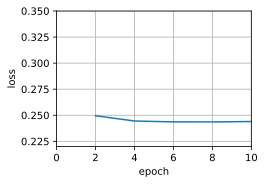

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，我们选择了很小的学习率。在随机梯度下降的实验中，每当一个样本被处理，模型参数都会更新。在这个例子中，这相当于每个迭代轮数有1500次更新。可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓。尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。

loss: 0.244, 0.081 sec/epoch


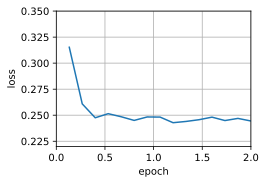

In [ ]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。

loss: 0.246, 0.005 sec/epoch


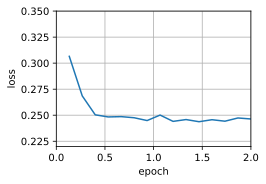

In [ ]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。

loss: 0.244, 0.013 sec/epoch


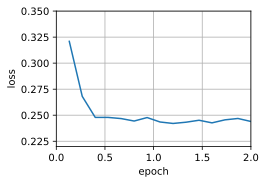

In [ ]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。小批量随机梯度下降能够平衡收敛速度和计算效率。大小为10的小批量比随机梯度下降更有效；大小为100的小批量在运行时间上甚至优于梯度下降。

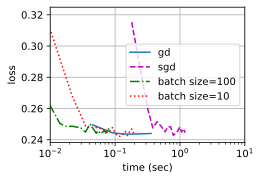

In [ ]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## 11.5.5. 简洁实现

In [ ]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.243, 0.014 sec/epoch


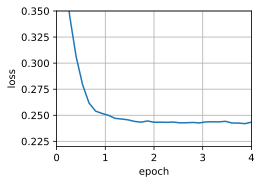

In [ ]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

# 11.6. 动量法

对于嘈杂的梯度，我们在选择学习率需要格外谨慎。如果衰减速度太快，收敛就会停滞。相反，如果太宽松，我们可能无法收敛到最优解。

## 11.6.1. 基础

在本节中，我们将探讨更有效的优化算法，尤其是针对实验中常见的某些类型的优化问题。

### 11.6.1.1. 泄漏平均值

### 11.6.1.2. 条件不佳的问题

epoch 20, x1: -0.943467, x2: -0.000073


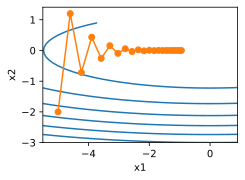

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: -0.387814, x2: -1673.365109


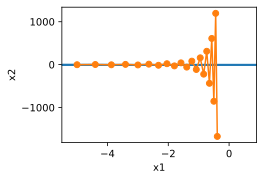

In [ ]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 11.6.1.3. 动量法

*动量法*（momentum）使我们能够解决上面描述的梯度下降问题。观察上面的优化轨迹，我们可能会直觉到计算过去的平均梯度效果会很好。毕竟，在$x_1$方向上，这将聚合非常对齐的梯度，从而增加我们在每一步中覆盖的距离。相反，在梯度振荡的$x_2$方向，由于相互抵消了对方的振荡，聚合梯度将减小步长大小。使用$\mathbf{v}_t$而不是梯度$\mathbf{g}_t$可以生成以下更新等式：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

请注意，对于$\beta = 0$，我们恢复常规的梯度下降。在深入研究它的数学属性之前，让我们快速看一下算法在实验中的表现如何。

epoch 20, x1: 0.007188, x2: 0.002553


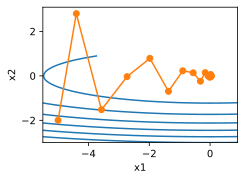

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

正如所见，尽管学习率与我们以前使用的相同，动量法仍然很好地收敛了。让我们看看当降低动量参数时会发生什么。将其减半至$\beta = 0.25$会导致一条几乎没有收敛的轨迹。尽管如此，它比没有动量时解将会发散要好得多。


epoch 20, x1: -0.126340, x2: -0.186632


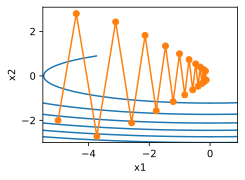

In [ ]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### 11.6.1.4. 有效样本权重

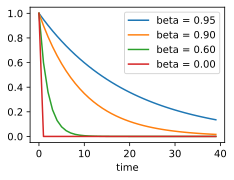

In [ ]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## 11.6.2. 实际实验

让我们来看看动量法在实验中是如何运作的。为此，我们需要一个更加可扩展的实现。

### 11.6.2.1. 从零开始实现

相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即速度。它与梯度以及优化问题的变量具有相同的形状。在下面的实现中，我们称这些变量为states。

In [ ]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [ ]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

让我们看看它在实验中是如何运作的。

loss: 0.244, 0.014 sec/epoch


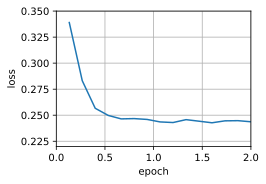

In [ ]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。我们将学习率略微降至$0.01$，以确保可控。


loss: 0.247, 0.015 sec/epoch


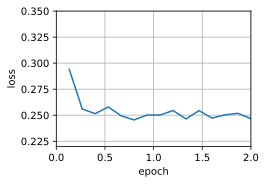

In [ ]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的困难，将其设置为$0.005$会产生良好的收敛性能。

loss: 0.247, 0.015 sec/epoch


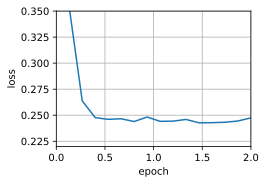

In [ ]:
train_momentum(0.005, 0.9)

### 11.6.2.2. 简洁实现

loss: 0.250, 0.015 sec/epoch


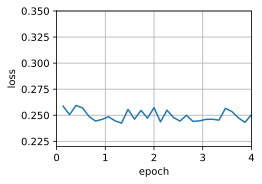

In [ ]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## 11.6.3. 理论分析

### 11.6.3.1. 二次凸函数

### 11.6.3.2. 标量函数

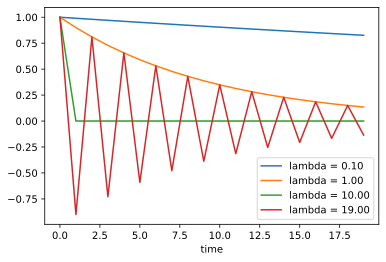

In [ ]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

# 11.7. AdaGrad算法

## 11.7.1. 稀疏特征和学习率

## 11.7.2. 预处理

## 11.7.3. 算法

然而，在深度学习中，我们可能希望更慢地降低学习率。这引出了许多AdaGrad算法的变体，我们将在后续章节中讨论它们。眼下让我们先看看它在二次凸问题中的表现如何。我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。


epoch 20, x1: -2.382563, x2: -0.158591


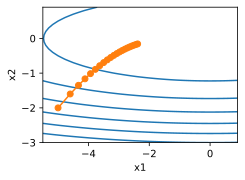

In [ ]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

我们将学习率提高到$2$，可以看到更好的表现。这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。

epoch 20, x1: -0.002295, x2: -0.000000


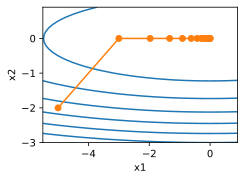

In [ ]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 11.7.4. 从零开始实现

In [ ]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.244, 0.016 sec/epoch


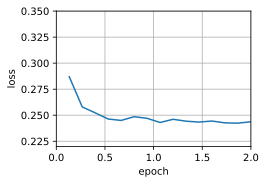

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 11.7.5. 简洁实现

loss: 0.243, 0.019 sec/epoch


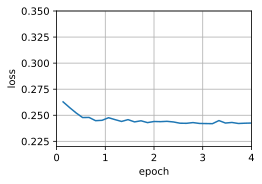

In [ ]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

# 11.8. RMSProp算法

## 11.8.1. 算法

In [ ]:
import math
import torch
from d2l import torch as d2l

d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## 11.8.2. 从零开始实现

和之前一样，我们使用二次函数$f(\mathbf{x})=0.1x_1^2+2x_2^2$来观察RMSProp算法的轨迹。回想，当我们使用学习率为0.4的Adagrad算法时，变量在算法的后期阶段移动非常缓慢，因为学习率衰减太快。RMSProp算法中不会发生这种情况，因为$\eta$是单独控制的。

epoch 20, x1: -0.010599, x2: 0.000000


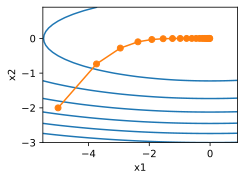

In [ ]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

接下来，我们在深度网络中实现RMSProp算法。

In [ ]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。


loss: 0.244, 0.018 sec/epoch


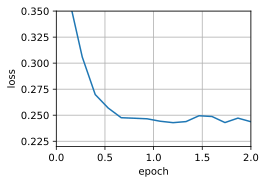

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## 11.8.3. 简洁实现

我们可直接使用深度学习框架中提供的RMSProp算法来训练模型。

loss: 0.243, 0.017 sec/epoch


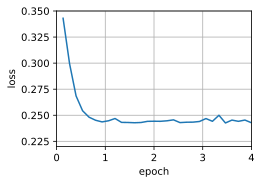

In [ ]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

# 11.9. Adadelta

Adadelta是AdaGrad的另一种变体，主要区别在于前者减少了学习率适应坐标的数量。此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。

## 11.9.1. Adadelta算法

## 11.9.2. 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实现。

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：

loss: 0.244, 0.028 sec/epoch


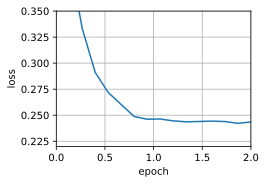

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用Trainer类中的adadelta算法。

loss: 0.243, 0.017 sec/epoch


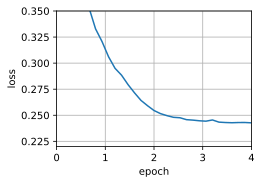

In [ ]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

# 11.10. Adam算法

## 11.10.1. 算法

## 11.10.2. 实现

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

现在，我们用以上Adam算法来训练模型，这里我们使用$\eta = 0.01$的学习率。

loss: 0.246, 0.020 sec/epoch


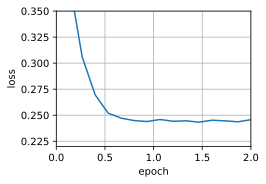

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

此外，我们可以用深度学习框架自带算法应用Adam算法，这里我们只需要传递配置参数。

loss: 0.243, 0.017 sec/epoch


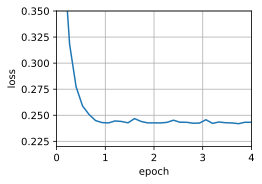

In [ ]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 11.10.3. Yogi

loss: 0.242, 0.023 sec/epoch


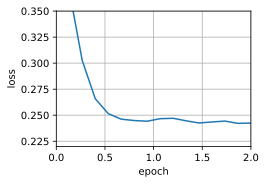

In [ ]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

# 11.11. 学习率调度器

## 11.11.1. 一个简单的问题

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用relu而不是sigmoid，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。此外，我们混合网络以提高性能。由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。

In [ ]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


让我们来看看如果使用默认设置，调用此算法会发生什么。例如设学习率为$0.3$并训练$30$次迭代。留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。两条曲线之间的间隙表示过拟合。


train loss 0.131, train acc 0.949, test acc 0.877


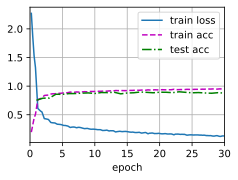

In [ ]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 11.11.2. 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。例如，以动态的方式来响应优化的进展情况。

In [ ]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。当调用更新次数时，它将返回学习率的适当值。让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [ ]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。

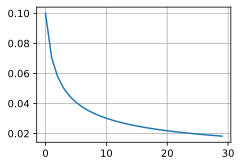

In [ ]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。我们只是提供调度器作为训练算法的额外参数。

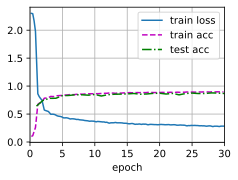

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 11.11.3. 策略

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。此外，余弦学习率调度在实践中的一些问题上运行效果很好。在某些问题上，最好在使用较高的学习率之前预热优化器。

### 11.11.3.1. 多因子调度器

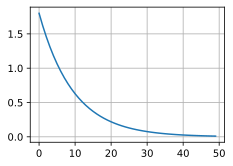

In [ ]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 11.11.3.2. 多因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。为了防止学习率衰减超出合理的下限，更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。

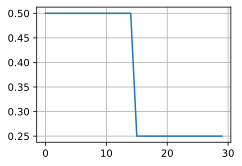

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。下面的例子展示了如何使用这种方法产生更好的解决方案。

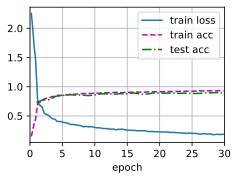

In [ ]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.3. 余弦调度器

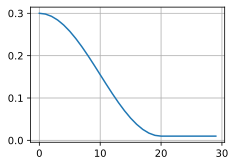

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉中，这个调度可以引出改进的结果。但请注意，如下所示，这种改进并不能保证成立。

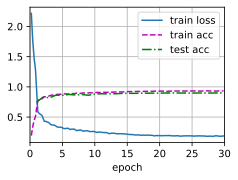

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.4. 预热

在某些情况下，初始化参数不足以得到良好的解。这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。对此，一方面，我们可以选择一个足够小的学习率，从而防止一开始发散，然而这样进展太缓慢。另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。为了简单起见，通常使用线性递增。这引出了如下表所示的时间表。

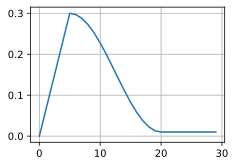

In [ ]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。

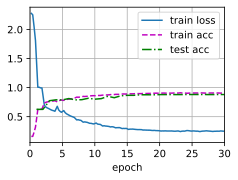

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热可以应用于任何调度器，而不仅仅是余弦。其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散量。这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。